In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def parse_out(file_path: str):
    # regex for the metrics line
    pattern = re.compile(
        r"Val NLL (?P<val_nll>[\d\.\-]+)\s*--\s*"
        r"Val Atom type KL: (?P<val_atom_kl>[\d\.\-]+)\s*--\s*"
        r"Val Edge type KL: (?P<val_edge_kl>[\d\.\-]+)\s*--\s*"
        r"Val Edge type logp: (?P<val_edge_logp>[\d\.\-]+)\s*--\s*"
        r"Val Edge type CE: (?P<val_edge_ce>[\d\.\-]+)"
    )

    # regex for the best val line
    best_pattern = re.compile(
        r"Val NLL: (?P<val_nll_detail>[\d\.]+)\s*Best Val NLL:\s*(?P<best_val_nll>[\d\.]+)"
    )

    records = []

    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                metrics = match.groupdict()
            else:
                continue

            # check for the "Val NLL: ... Best Val NLL: ..." on same line
            best_match = best_pattern.search(line)
            if best_match:
                metrics.update(best_match.groupdict())

            records.append(metrics)

    # put into dataframe
    df = pd.DataFrame(records)
    df = df.apply(pd.to_numeric, errors="ignore")
    return df

In [3]:
df_anomaly = parse_out('data/expr2.out')
df_anomaly.iloc[30:50]

,val_nll,val_atom_kl,val_edge_kl,val_edge_logp,val_edge_ce
30,102.59,0.03,0.17,-0.02,0.19
31,103.79,0.03,0.17,-0.02,0.19
32,98.59,0.03,0.16,-0.03,0.19
33,103.06,0.03,0.17,-0.03,0.19
34,101.05,0.03,0.16,-0.01,0.19
35,101.13,0.03,0.17,-0.01,0.19
36,102.02,0.03,0.17,-0.01,0.19
37,100.48,0.03,0.16,-0.03,0.19
38,200.43,0.03,0.30,-30.87,0.25
39,140.15,0.03,0.24,-0.11,0.20


In [4]:
experiments = {
    'Experiment 1': 'expr1.out',
    'Experiment 2.1': 'expr2.1.out',
    'Experiment 2.2': 'expr2.2.out',
    'Experiment 3': 'expr3.out'
}
dfs = []
for expr_name, file_name in experiments.items():
    file_path = 'data/' + file_name
    print(file_path)
    dfs.append(parse_out(file_path))

data/expr1.out
data/expr2.1.out


FileNotFoundError: [Errno 2] No such file or directory: 'data/expr2.1.out'

In [7]:
fs=9
plt.rcParams.update({'font.size': fs})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

In [8]:
colors = ['#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          "#AFAFAF",  # light gray '#89bebf': TopFP
          '#f5bad3',   # soft pink / baby pink: ATMO 
          '#e1aee4',  # pastel pink-purple / light orchid: ATMOMACCS v1
          '#bdabbf',  # muted lavender / dusty lilac: ATMOMACCS v2
          "#282f2f",  # light aqua / pale cyan: : ATMOMACCS v3
          '#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          '#8995BF'  # desaturated periwinkle / dusty indigo: : ATMOMACCS v5
         ]

/tmp/ipykernel_22083/3083541013.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


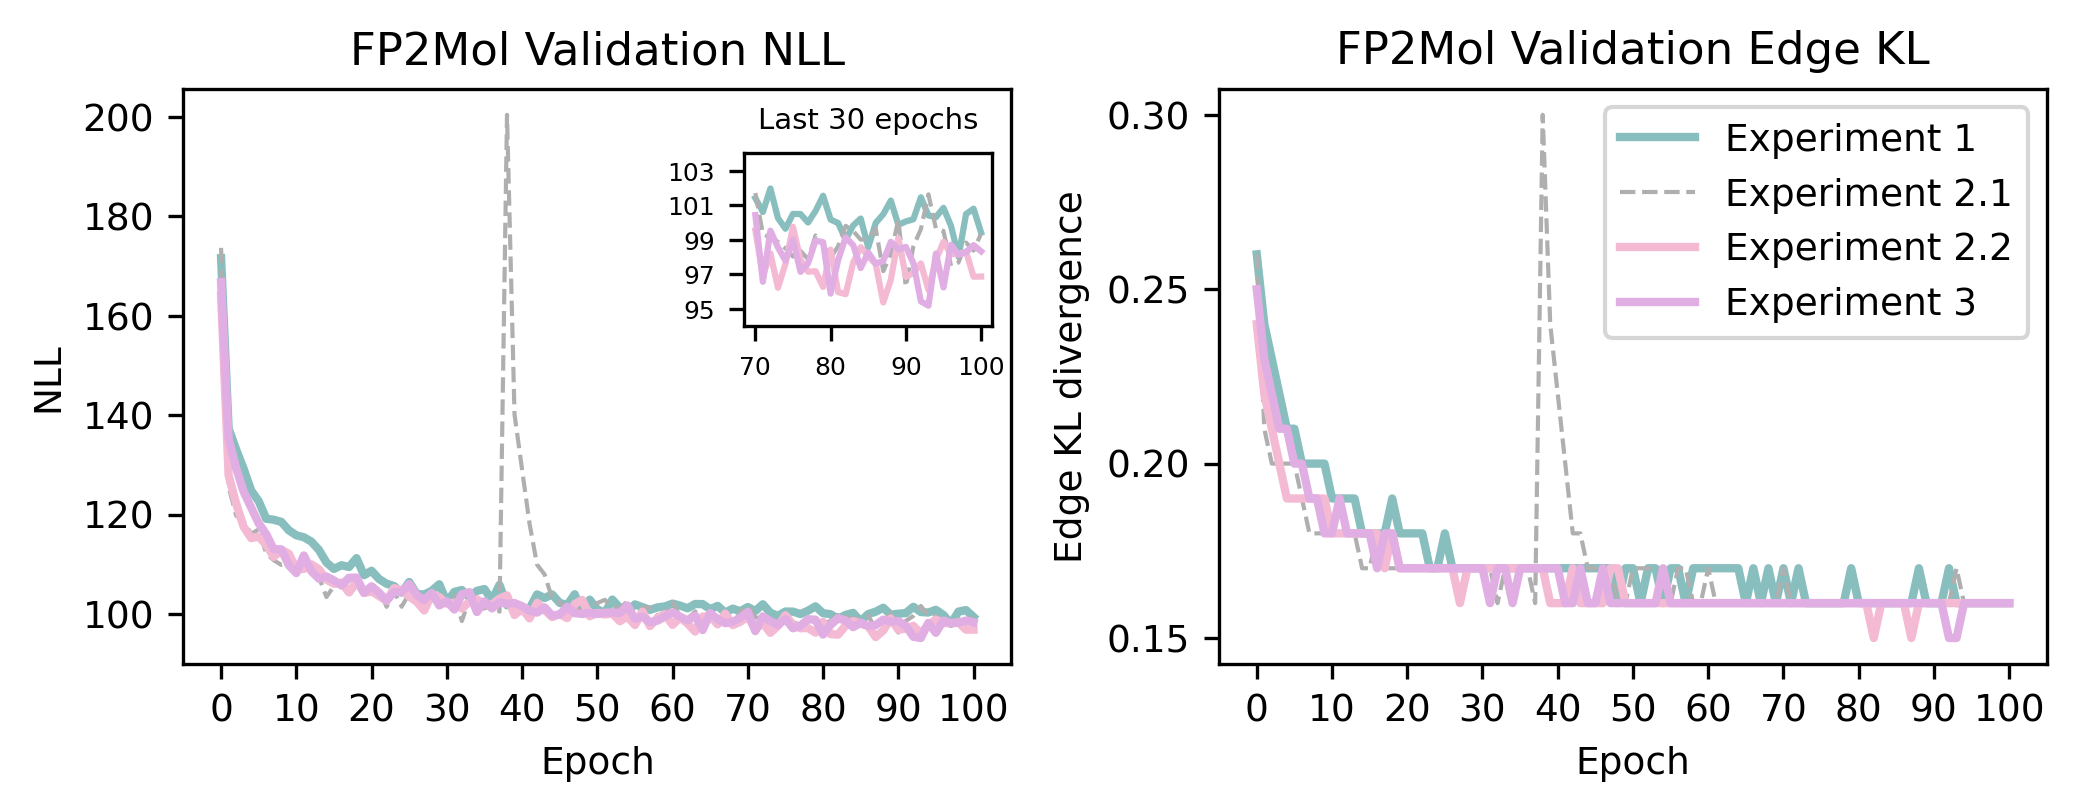

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(504/72, 200/72), sharex=True, dpi=300)

labels = experiments.keys()

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    if label == 'Experiment 2.1':
        axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=1, linestyle='--')
        axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=1, linestyle='--')
    else:
        axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=2)
        axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=2)
axes[0].set_title("FP2Mol Validation NLL")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("NLL")
axes[0].set_xticks(np.linspace(0, 100, 11))
axes[0].set_yticks(np.linspace(100, 200, 6))

axes[1].set_title("FP2Mol Validation Edge KL")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Edge KL divergence")
axes[1].set_xticks(np.linspace(0, 100, 11))
axes[1].set_yticks(np.linspace(0.15, 0.3, 4))

axes[1].legend()

# --- inset zoom of last 15 epochs ---
ax_inset = inset_axes(axes[0], width="30%", height="30%", loc="upper right",
                      bbox_to_anchor=(-0.0, -0.08, 1.0, 1.0),  # x0, y0, width, height
                      bbox_transform=axes[0].transAxes)

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    y = df['val_nll'].values
    mask = x >= (x.max() - 30)
    if label == 'Experiment 2.1':
        ax_inset.plot(x[mask], y[mask], color=color, lw=1, linestyle='--')
    else:
        ax_inset.plot(x[mask], y[mask], color=color, lw=1.5)
    ax_inset.set_yticks([95, 97, 99, 101, 103])
    ax_inset.set_ylim([94,104])
    ax_inset.set_xticks([70, 80, 90, 100])

ax_inset.set_title("Last 30 epochs", fontsize=fs-2)
ax_inset.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig("figs/fp2mol_nll_edge_kl.png", dpi=300)
plt.show()

In [44]:
experiments = {
    'Peak strategy 2': 'peak_strategy_2.out',
    'Peak removal 3': 'peak_removal_3.out',
    'Peak noising 3': 'peak_noising_3.out'
}
dfs = []
for expr_name, file_name in experiments.items():
    file_path = 'data/' + file_name
    print(file_path)
    dfs.append(parse_out(file_path))

data/peak_strategy_2.out
data/peak_removal_3.out
data/peak_noising_3.out


Peak strategy 2: 112.15225806451612, (110.42, 114.93)
Peak removal 3: 112.2116129032258, (110.23, 114.73)
Peak noising 3: 111.98387096774195, (109.39, 114.1)


C:\Users\kuuli\AppData\Local\Temp\ipykernel_3380\2604803080.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


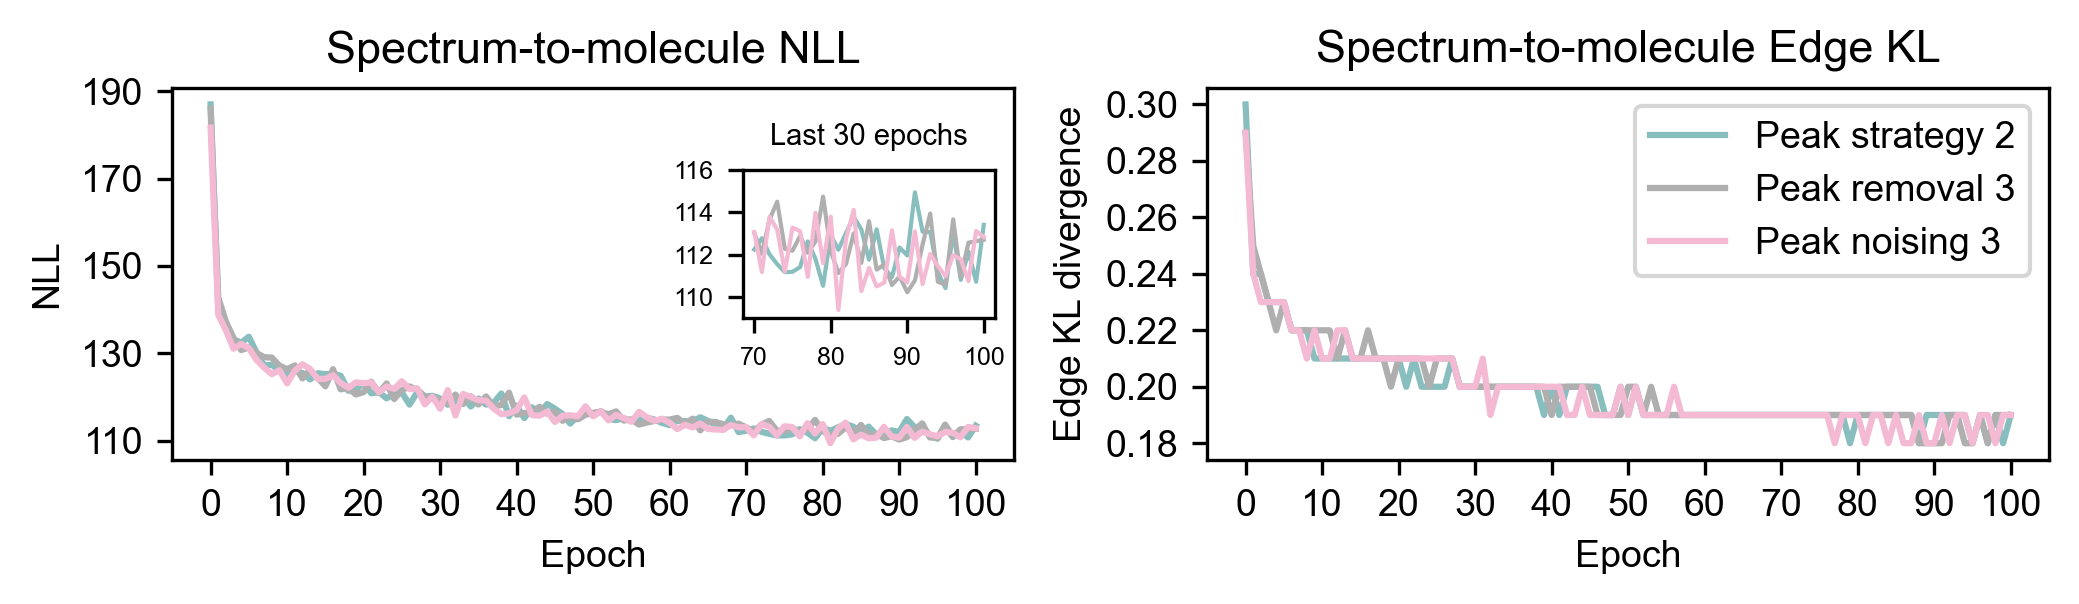

In [45]:
colors = ['#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          "#AFAFAF",  # light gray '#89bebf': TopFP
          '#f5bad3',   # soft pink / baby pink: ATMO 
          '#e1aee4',  # pastel pink-purple / light orchid: ATMOMACCS v1
          '#bdabbf',  # muted lavender / dusty lilac: ATMOMACCS v2
          "#282f2f",  # light aqua / pale cyan: : ATMOMACCS v3
          '#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          '#8995BF'  # desaturated periwinkle / dusty indigo: : ATMOMACCS v5
         ]
fig, axes = plt.subplots(1, 2, figsize=(504/72, 150/72), sharex=True, dpi=300)

labels = experiments.keys()

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    if label == 'Experiment 2.1':
        axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=1, linestyle='--')
        axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=1, linestyle='--')
    else:
        axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=1.5)
        axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=1.5)
axes[0].set_title("Spectrum-to-molecule NLL")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("NLL")
axes[0].set_xticks(np.linspace(0, 100, 11))
axes[0].set_yticks(np.linspace(110, 190, 5))

axes[1].set_title("Spectrum-to-molecule Edge KL")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Edge KL divergence")
axes[1].set_xticks(np.linspace(0, 100, 11))
axes[1].set_yticks(np.linspace(0.18, 0.3, 7))

axes[1].legend()

# --- inset zoom of last 15 epochs ---
ax_inset = inset_axes(axes[0], width="30%", height="30%", loc="upper right",
                      bbox_to_anchor=(-0.0, -0.5, 1.0, 1.33),  # x0, y0, width, height
                      bbox_transform=axes[0].transAxes)
for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    y = df['val_nll'].values
    mask = x >= (x.max() - 30)
    if label == 'Experiment 2.1':
        ax_inset.plot(x[mask], y[mask], color=color, lw=1, linestyle='--')
    else:
        ax_inset.plot(x[mask], y[mask], color=color, lw=1)
    ax_inset.set_yticks([110, 112, 114, 116])
    ax_inset.set_ylim([109,116])
    ax_inset.set_xticks([70, 80, 90, 100])
    print(f'{label}: {np.mean(y[mask])}, ({np.min(y[mask])}, {np.max(y[mask])})')

ax_inset.set_title("Last 30 epochs", fontsize=fs-2)
ax_inset.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig("figs/spec2mol_nll_edge_kl.png", dpi=300)
plt.show()

In [47]:
experiments = {
    'Baseline': 'baseline.out',
    'Peak scaling 3': 'peak_scaling_3.out',
    'Peak scaling 2': 'peak_scaling_2.out'
}
dfs = []
for expr_name, file_name in experiments.items():
    file_path = 'data/' + file_name
    print(file_path)
    dfs.append(parse_out(file_path))

data/baseline.out
data/peak_scaling_3.out
data/peak_scaling_2.out


Baseline: 117.79645161290323, (115.65, 120.65)
Peak scaling 3: 119.7741935483871, (117.99, 121.97)
Peak scaling 2: 112.39129032258064, (110.09, 115.29)


C:\Users\kuuli\AppData\Local\Temp\ipykernel_3380\733158285.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


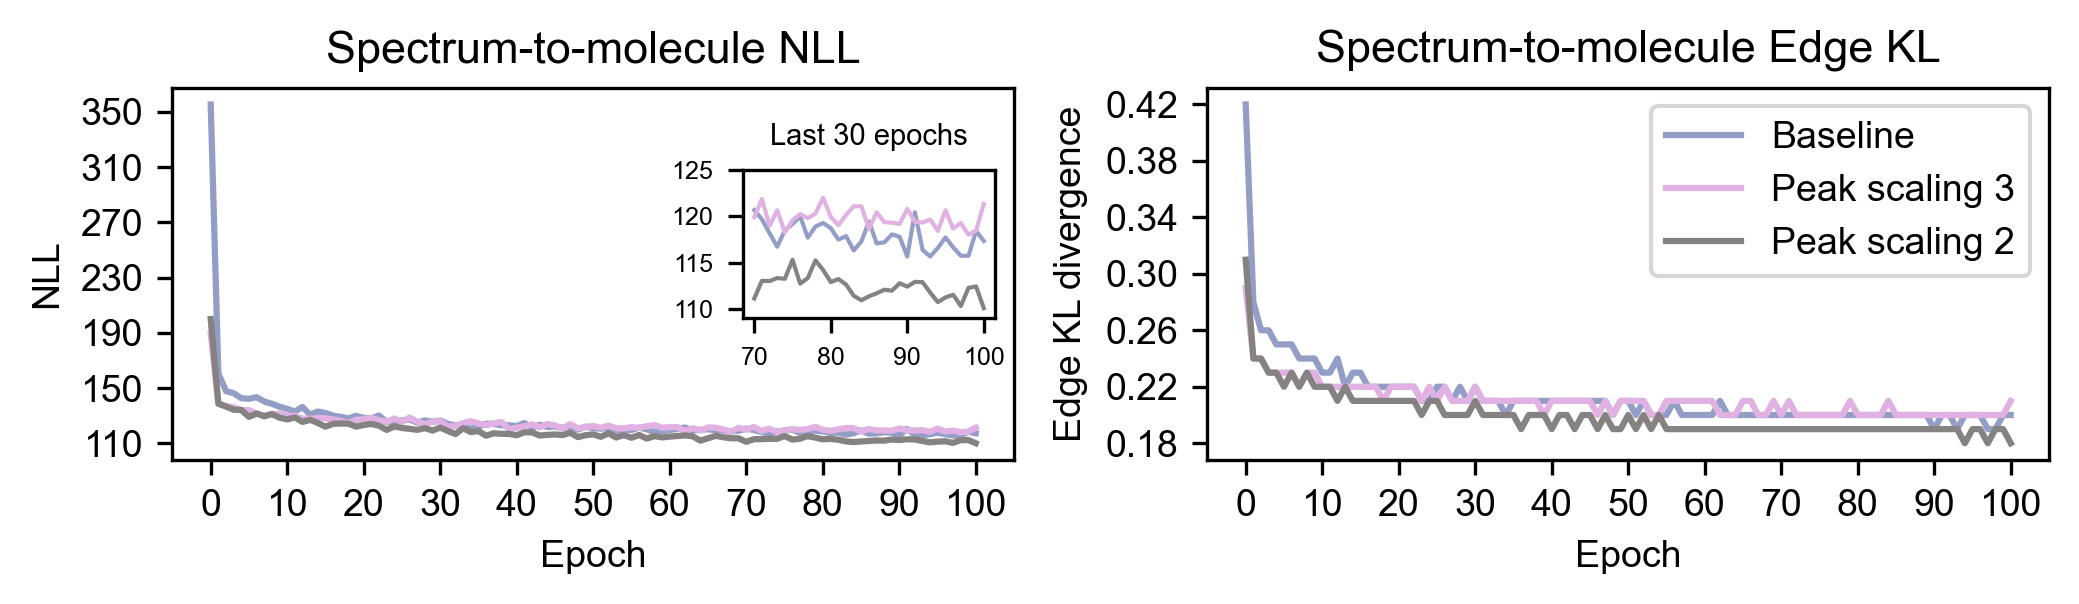

In [48]:
colors = [
            "#939EC6",  # desaturated periwinkle / dusty indigo: : ATMOMACCS v5
          "#e0b1e2",  # pastel pink-purple / light orchid: ATMOMACCS v1
          "#868282",  # light aqua / pale cyan: : ATMOMACCS v3
          '#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
         ]
fig, axes = plt.subplots(1, 2, figsize=(504/72, 150/72), sharex=True, dpi=300)

labels = experiments.keys()

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    if label == 'Experiment 2.1':
        axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=1, linestyle='--')
        axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=1, linestyle='--')
    else:
        axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=1.5)
        axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=1.5)
axes[0].set_title("Spectrum-to-molecule NLL")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("NLL")
axes[0].set_xticks(np.linspace(0, 100, 11))
axes[0].set_yticks(np.linspace(110, 350, 7))

axes[1].set_title("Spectrum-to-molecule Edge KL")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Edge KL divergence")
axes[1].set_xticks(np.linspace(0, 100, 11))
axes[1].set_yticks(np.linspace(0.18, 0.42, 7))

axes[1].legend()

# --- inset zoom of last 15 epochs ---
ax_inset = inset_axes(axes[0], width="30%", height="30%", loc="upper right",
                      bbox_to_anchor=(-0.0, -0.5, 1.0, 1.33),  # x0, y0, width, height
                      bbox_transform=axes[0].transAxes)

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    y = df['val_nll'].values
    mask = x >= (x.max() - 30)
    if label == 'Experiment 2.1':
        ax_inset.plot(x[mask], y[mask], color=color, lw=1, linestyle='--')
    else:
        ax_inset.plot(x[mask], y[mask], color=color, lw=1)
    ax_inset.set_yticks(np.linspace(110, 125, 4))
    ax_inset.set_ylim([109,125])
    ax_inset.set_xticks([70, 80, 90, 100])
    print(f'{label}: {np.mean(y[mask])}, ({np.min(y[mask])}, {np.max(y[mask])})')

ax_inset.set_title("Last 30 epochs", fontsize=fs-2)
ax_inset.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig("figs/spec2mol_worst_nll_edge_kl.png", dpi=300)
plt.show()

In [ ]:
experiments = {
    'Encoder 1': 'no_encoder_pretrain.out',
    'Encoder 2': '50_epoch_fast_pretrain.out',
    'Encoder 3': '100_epoch_slow_pretrain.out'
}
dfs = []
for expr_name, file_name in experiments.items():
    file_path = 'data/' + file_name
    print(file_path)
    dfs.append(parse_out(file_path))

data/no_encoder_pretrain.out
data/50_epoch_fast_pretrain.out
data/100_epoch_slow_pretrain.out


C:\Users\kuuli\AppData\Local\Temp\ipykernel_17820\1337389850.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


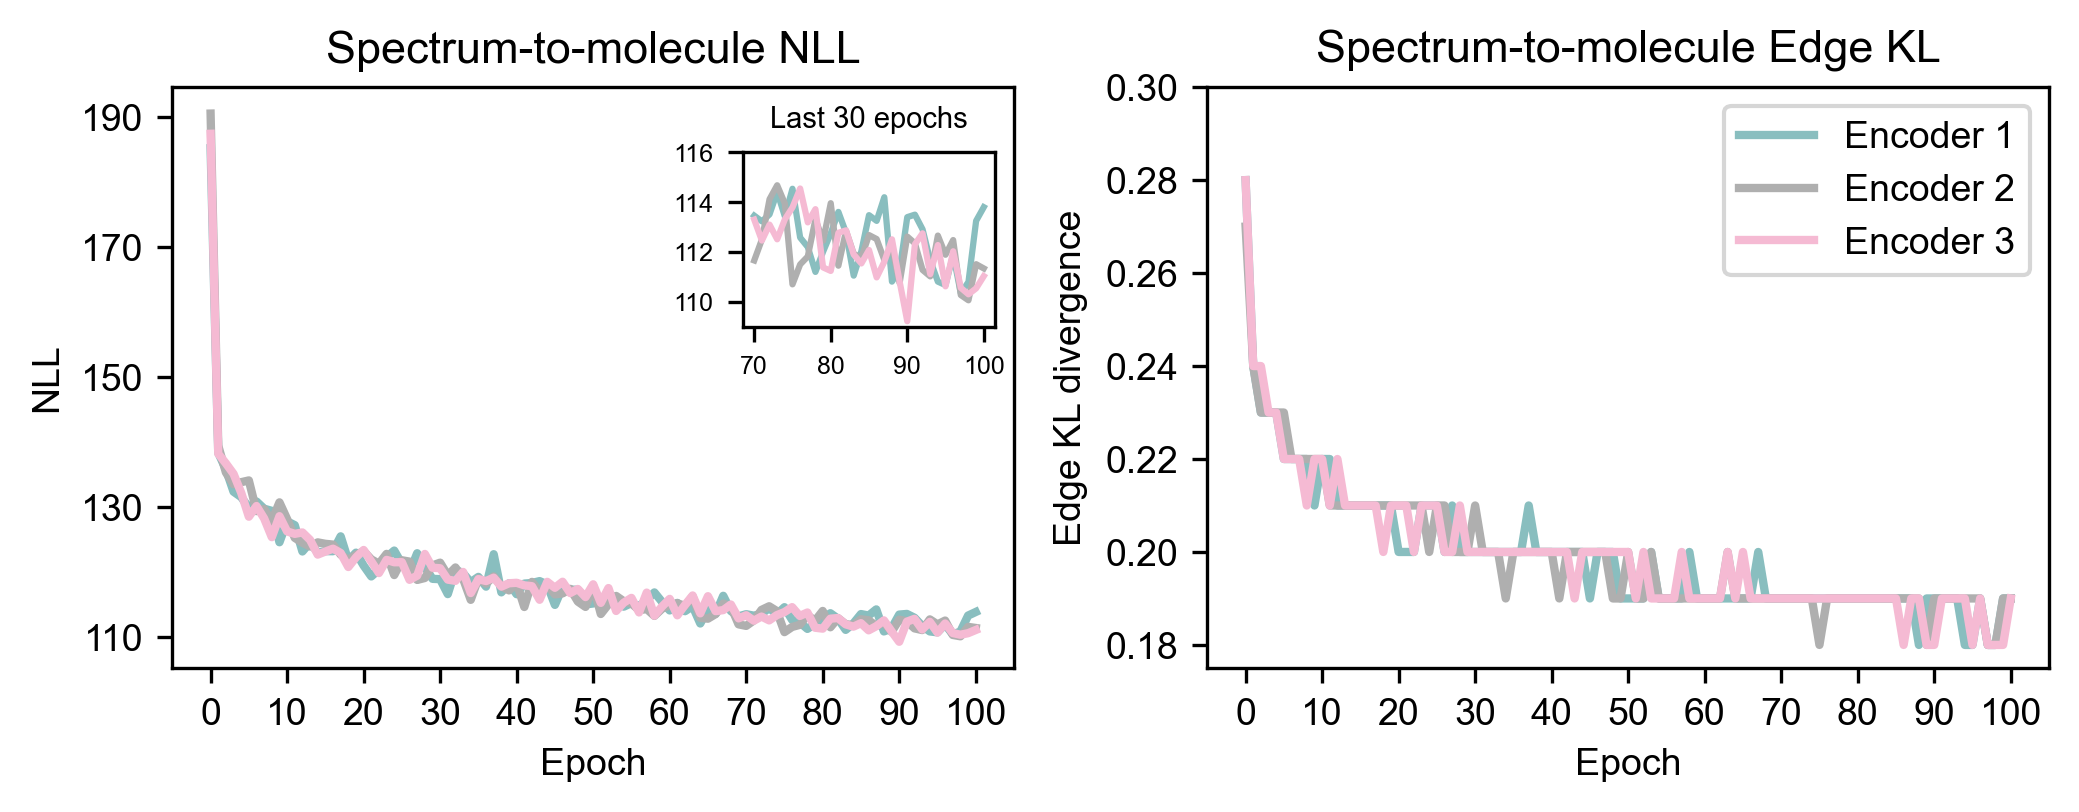

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(504/72, 200/72), sharex=True, dpi=300)

labels = experiments.keys()

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    if label == 'Experiment 2.1':
        axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=1, linestyle='--')
        axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=1, linestyle='--')
    else:
        axes[0].plot(x, df['val_nll'].values, label=label, color=color, lw=2)
        axes[1].plot(x, df['val_edge_kl'].values, label=label, color=color, lw=2)
axes[0].set_title("Spectrum-to-molecule NLL")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("NLL")
axes[0].set_xticks(np.linspace(0, 100, 11))
axes[0].set_yticks(np.linspace(110, 190, 5))

axes[1].set_title("Spectrum-to-molecule Edge KL")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Edge KL divergence")
axes[1].set_xticks(np.linspace(0, 100, 11))
axes[1].set_yticks(np.linspace(0.18, 0.3, 7))

axes[1].legend()

# --- inset zoom of last 15 epochs ---
ax_inset = inset_axes(axes[0], width="30%", height="30%", loc="upper right",
                      bbox_to_anchor=(-0.0, -0.08, 1.0, 1.0),  # x0, y0, width, height
                      bbox_transform=axes[0].transAxes)

for df, label, color in zip(dfs, labels, colors):
    x = df.index.values
    y = df['val_nll'].values
    mask = x >= (x.max() - 30)
    if label == 'Experiment 2.1':
        ax_inset.plot(x[mask], y[mask], color=color, lw=1, linestyle='--')
    else:
        ax_inset.plot(x[mask], y[mask], color=color, lw=1.5)
    ax_inset.set_yticks([110, 112, 114, 116])
    ax_inset.set_ylim([109,116])
    ax_inset.set_xticks([70, 80, 90, 100])

ax_inset.set_title("Last 30 epochs", fontsize=fs-2)
ax_inset.tick_params(axis='both', which='major', labelsize=6)


plt.tight_layout()
plt.savefig("figs/spec2mol_encoder_nll_edge_kl.png", dpi=300)
plt.show()

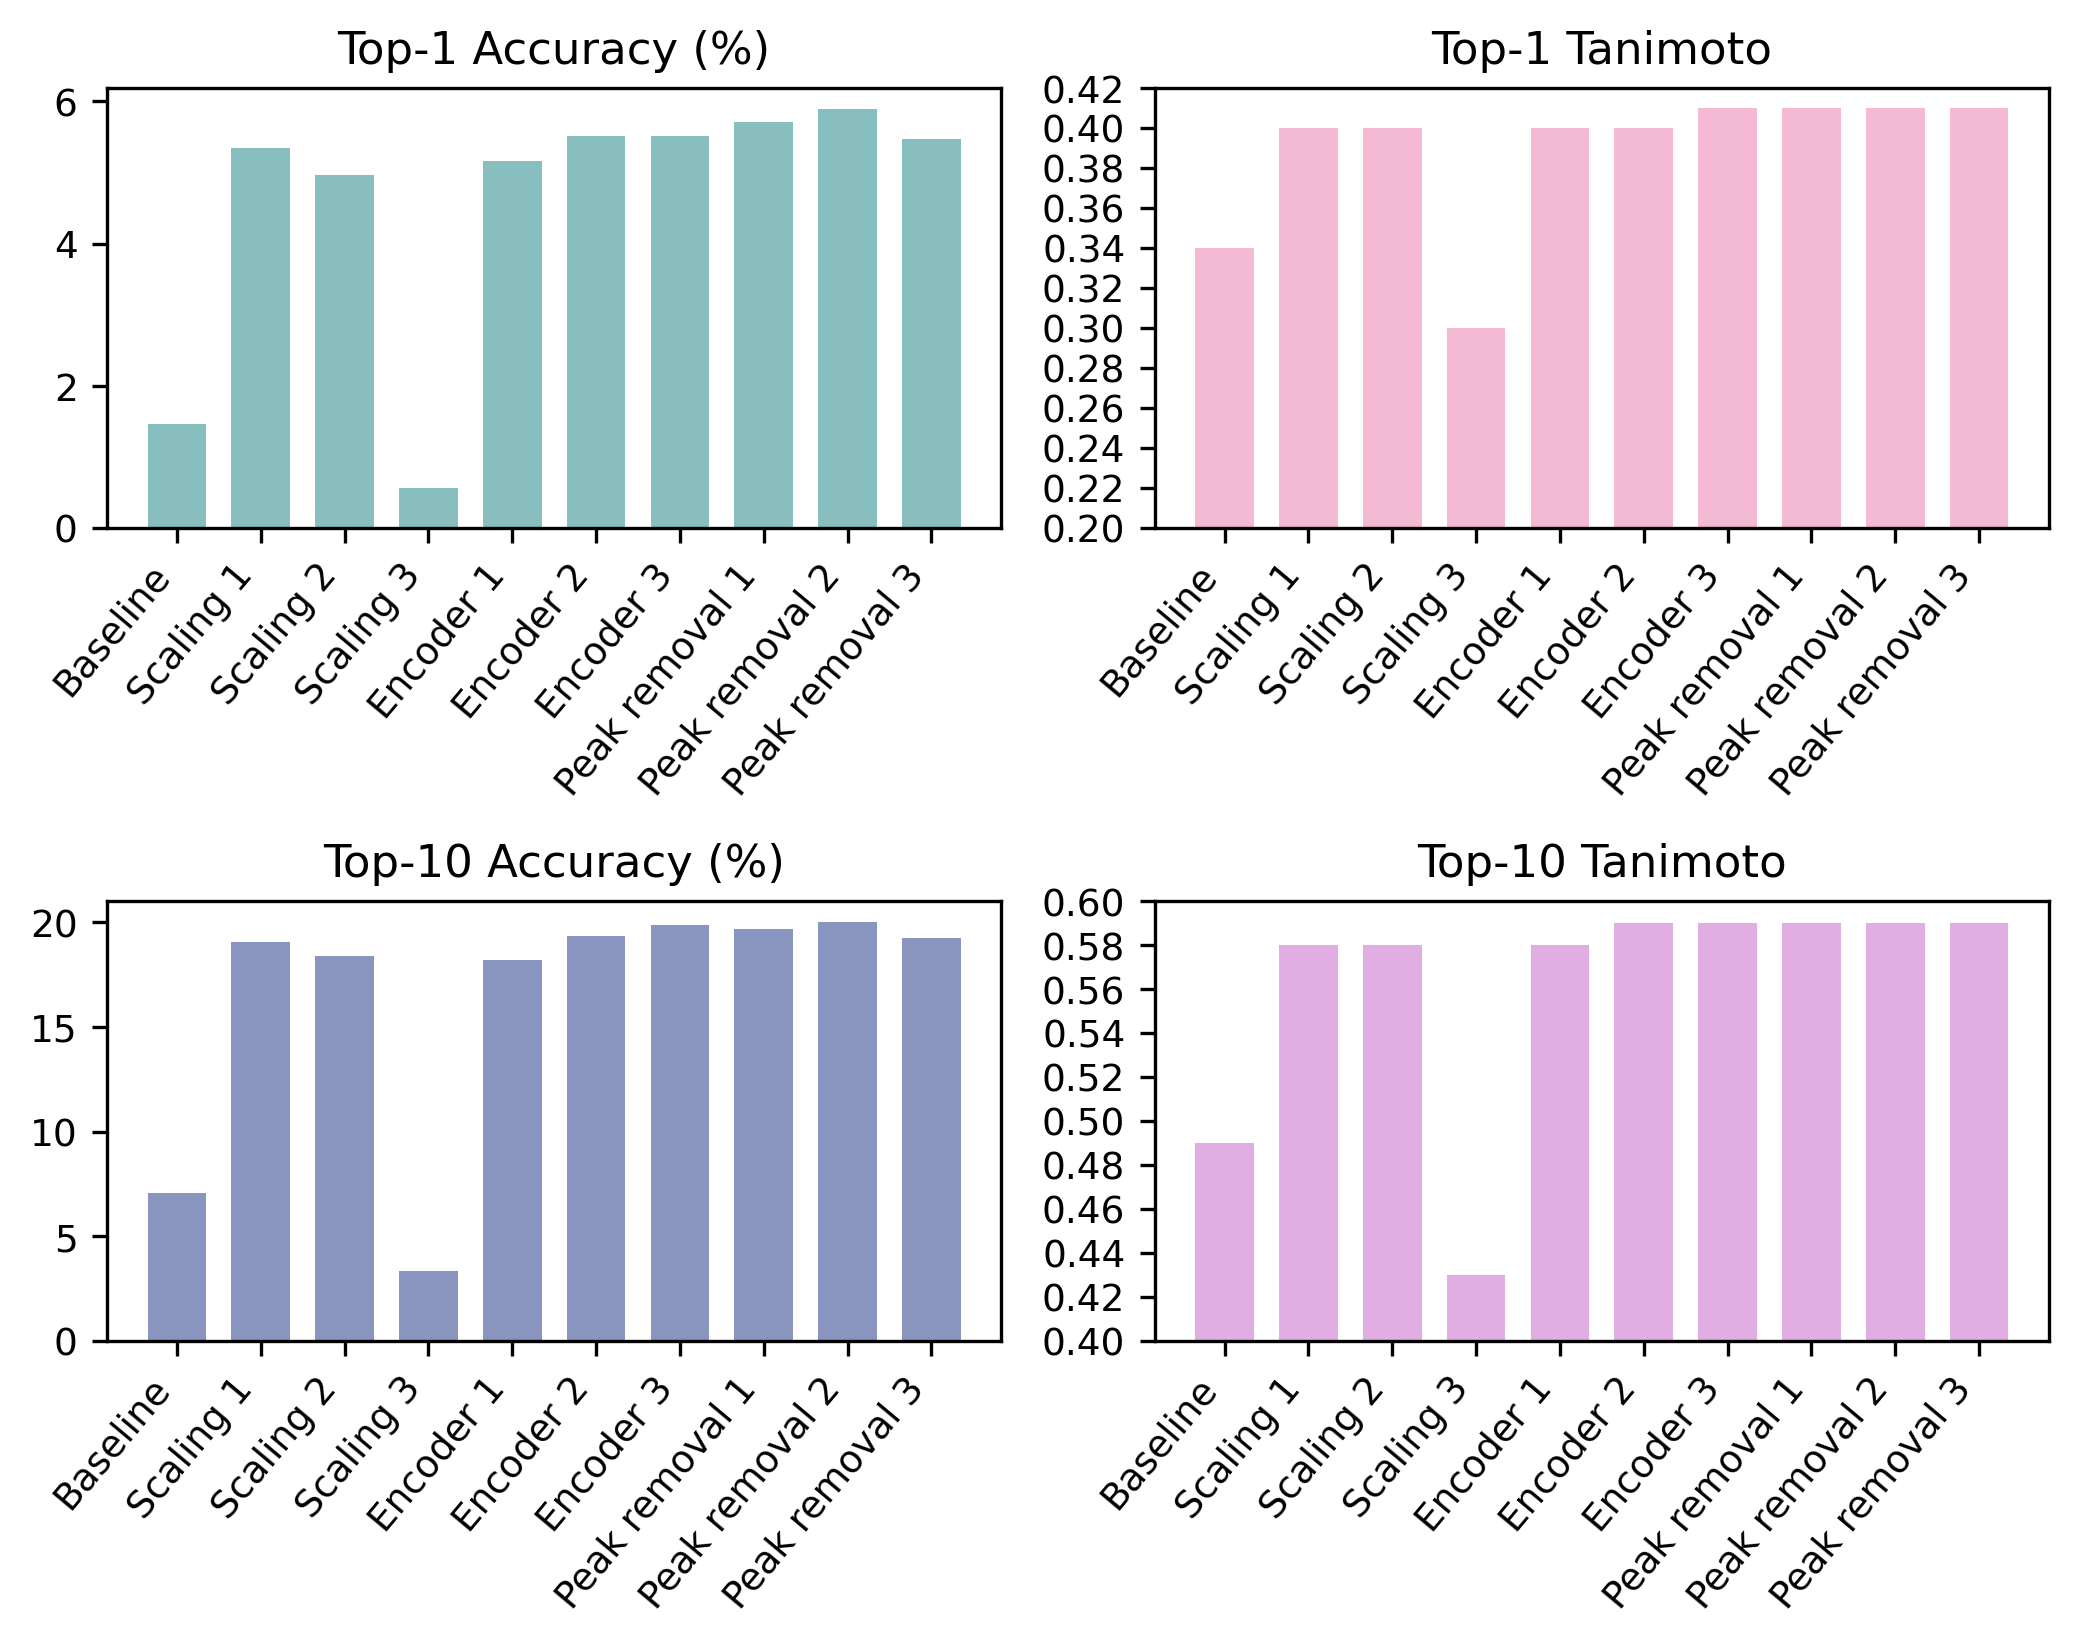

In [ ]:
# Example: converting your table into a DataFrame
data = {
    "Experiment": [
        "Baseline", "Scaling 1", "Scaling 2", "Scaling 3",
        "Encoder 1", "Encoder 2", "Encoder 3",
        "Peak removal 1", "Peak removal 2", "Peak removal 3"
    ],
    "Top-1 Accuracy": [1.46, 5.35, 4.96, 0.57, 5.16, 5.52, 5.51, 5.71, 5.89, 5.47],
    "Top-1 Tanimoto": [0.34, 0.40, 0.40, 0.30, 0.40, 0.40, 0.41, 0.41, 0.41, 0.41],
    "Top-10 Accuracy": [7.08, 19.07, 18.4, 3.33, 18.22, 19.33, 19.89, 19.7, 20.0, 19.24],
    "Top-10 Tanimoto": [0.49, 0.58, 0.58, 0.43, 0.58, 0.59, 0.59, 0.59, 0.59, 0.59],
    "Validity": [93.44, 95.17, 95.12, 96.30, 95.48, 95.28, 95.17, 95.03, 95.11, 95.20]
}

colors = ['#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          '#949494',  # light gray '#89bebf': TopFP
          '#f5bad3',   # soft pink / baby pink: ATMO 
          '#e1aee4',  # pastel pink-purple / light orchid: ATMOMACCS v1
          '#bdabbf',  # muted lavender / dusty lilac: ATMOMACCS v2
          "#282f2f",  # light aqua / pale cyan: : ATMOMACCS v3
          '#89bebf',  # muted teal / soft cyan: ATMOMACCS v4
          '#8995BF'  # desaturated periwinkle / dusty indigo: : ATMOMACCS v5
         ]

df = pd.DataFrame(data)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(504/72, 200/72*2), dpi =300)

x = np.arange(len(df))  # positions
width = 0.7
rot_amt = 50

# Top-1 Accuracy
axes[0,0].bar(x, df["Top-1 Accuracy"], width, color='#89bebf')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(df["Experiment"], rotation=rot_amt, ha='right')
axes[0,0].set_title("Top-1 Accuracy (%)")

# Top-1 Tanimoto
axes[0,1].bar(x, df["Top-1 Tanimoto"], width, color='#f5bad3')
axes[0,1].set_xticks(x)
axes[0,1].set_ylim([0.2,0.42])
axes[0,1].set_yticks(np.linspace(0.2, 0.42, 12))
axes[0,1].set_xticklabels(df["Experiment"], rotation=rot_amt, ha='right')
axes[0,1].set_title("Top-1 Tanimoto")

# Top-10 Accuracy
axes[1,0].bar(x, df["Top-10 Accuracy"], width, color='#8995BF')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(df["Experiment"], rotation=rot_amt, ha='right')
axes[1,0].set_title("Top-10 Accuracy (%)")

# Top-10 Tanimoto
axes[1,1].bar(x, df["Top-10 Tanimoto"], width, color='#e1aee4')
axes[1,1].set_xticks(x)
axes[1,1].set_ylim([0.4,0.6])
axes[1,1].set_xticklabels(df["Experiment"], rotation=rot_amt, ha='right')
axes[1,1].set_yticks(np.linspace(0.4, 0.6, 11))
axes[1,1].set_title("Top-10 Tanimoto")

plt.tight_layout()
plt.show()


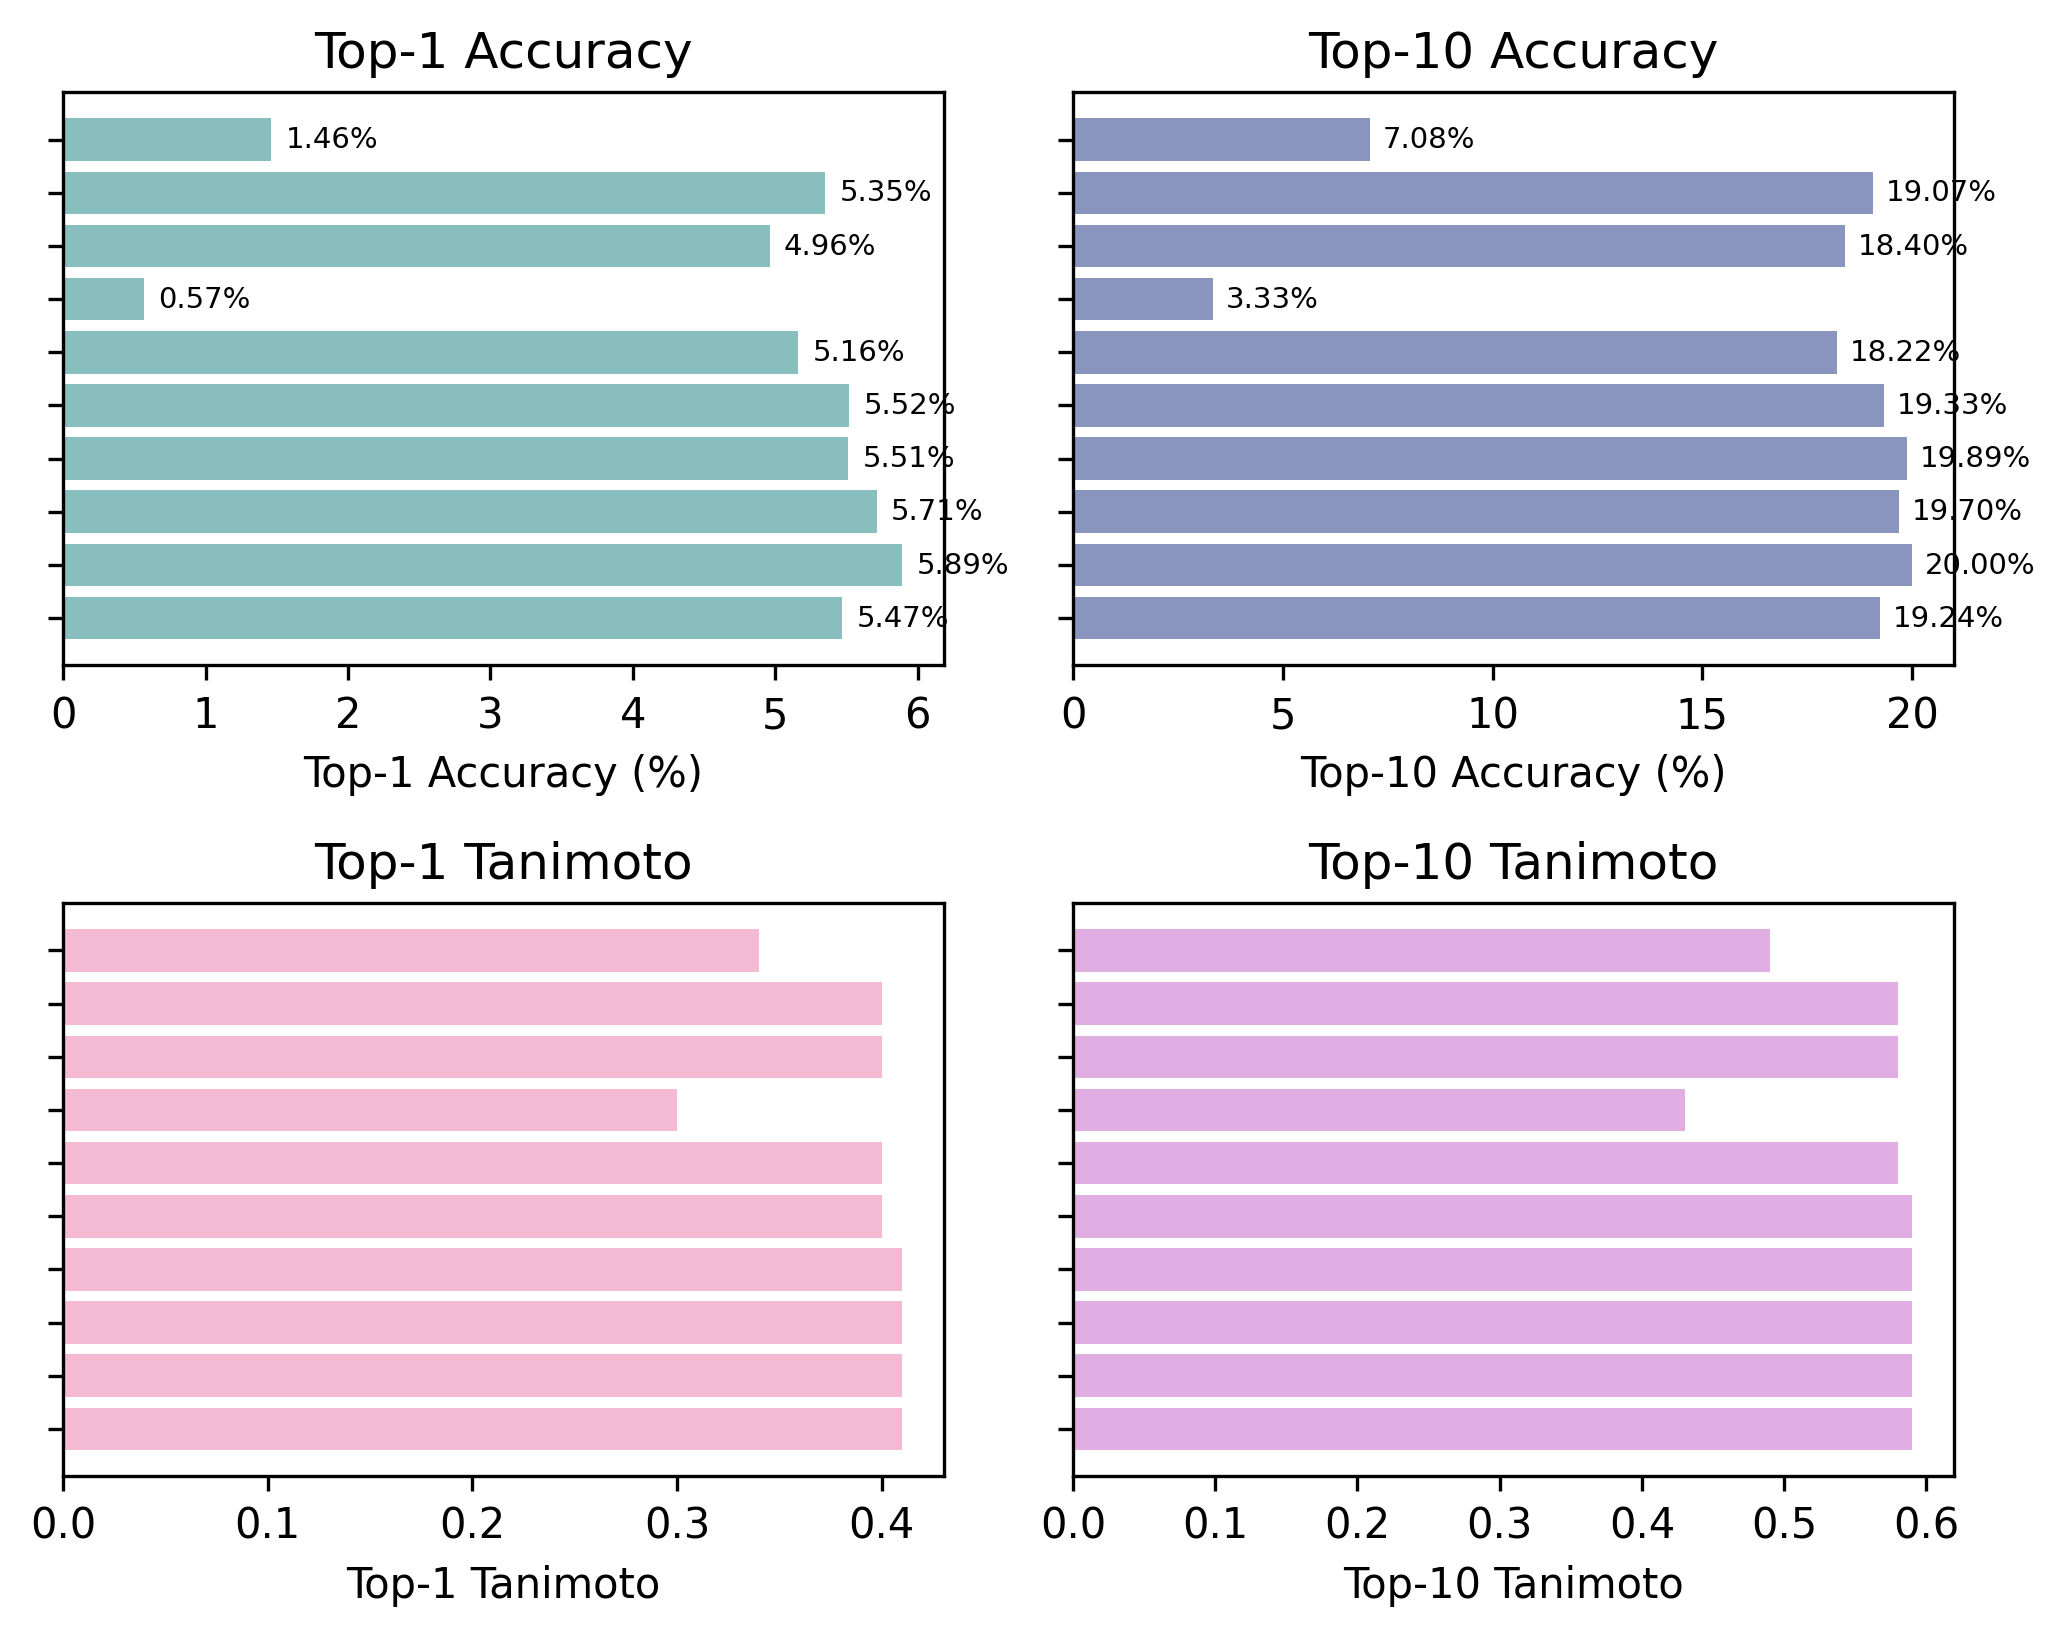

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    "Experiment": [
        "Baseline", "Scaling 1", "Scaling 2", "Scaling 3",
        "Encoder 1", "Encoder 2", "Encoder 3",
        "Peak removal 1", "Peak removal 2", "Peak removal 3"
    ],
    "Top-1 Accuracy": [1.46, 5.35, 4.96, 0.57, 5.16, 5.52, 5.51, 5.71, 5.89, 5.47],
    "Top-1 Tanimoto": [0.34, 0.40, 0.40, 0.30, 0.40, 0.40, 0.41, 0.41, 0.41, 0.41],
    "Top-10 Accuracy": [7.08, 19.07, 18.4, 3.33, 18.22, 19.33, 19.89, 19.7, 20.0, 19.24],
    "Top-10 Tanimoto": [0.49, 0.58, 0.58, 0.43, 0.58, 0.59, 0.59, 0.59, 0.59, 0.59]
}

df = pd.DataFrame(data)
experiments = df["Experiment"].values
y_pos = np.arange(len(experiments))

# Colors for each plot
colors = ['#89bebf', '#8995BF', '#f5bad3', '#e1aee4']

# Figure
fig, axes = plt.subplots(2, 2, figsize=(504/72, 200/72*2), dpi=300, sharey=True)

# Top-1 Accuracy
bars1 = axes[0,0].barh(y_pos, df["Top-1 Accuracy"], color=colors[0])
axes[0,0].set_yticks(y_pos)
axes[0,0].set_yticklabels(experiments)
axes[0,0].set_xlabel("Top-1 Accuracy (%)")
axes[0,0].set_title("Top-1 Accuracy")

for bar, val in zip(bars1, df["Top-1 Accuracy"]):
    axes[0,0].text(val + 0.1, bar.get_y() + bar.get_height()/2,
                   f"{val:.2f}%", va='center', fontsize=7)

# Top-10 Accuracy
bars2 = axes[0,1].barh(y_pos, df["Top-10 Accuracy"], color=colors[1])
axes[0,1].set_yticks(y_pos)
axes[0,1].set_yticklabels([])  # hide yticklabels on the right
axes[0,1].set_xlabel("Top-10 Accuracy (%)")
axes[0,1].set_title("Top-10 Accuracy")

for bar, val in zip(bars2, df["Top-10 Accuracy"]):
    axes[0,1].text(val + 0.3, bar.get_y() + bar.get_height()/2,
                   f"{val:.2f}%", va='center', fontsize=7)

# Top-1 Tanimoto
axes[1,0].barh(y_pos, df["Top-1 Tanimoto"], color=colors[2])
axes[1,0].set_yticks(y_pos)
axes[1,0].set_yticklabels(experiments)
axes[1,0].set_xlabel("Top-1 Tanimoto")
axes[1,0].set_title("Top-1 Tanimoto")

# Top-10 Tanimoto
axes[1,1].barh(y_pos, df["Top-10 Tanimoto"], color=colors[3])
axes[1,1].set_yticks(y_pos)
axes[1,1].set_yticklabels([])  # hide yticklabels on the right
axes[1,1].set_xlabel("Top-10 Tanimoto")
axes[1,1].set_title("Top-10 Tanimoto")
axes[1,1].invert_yaxis()

plt.tight_layout()
plt.show()


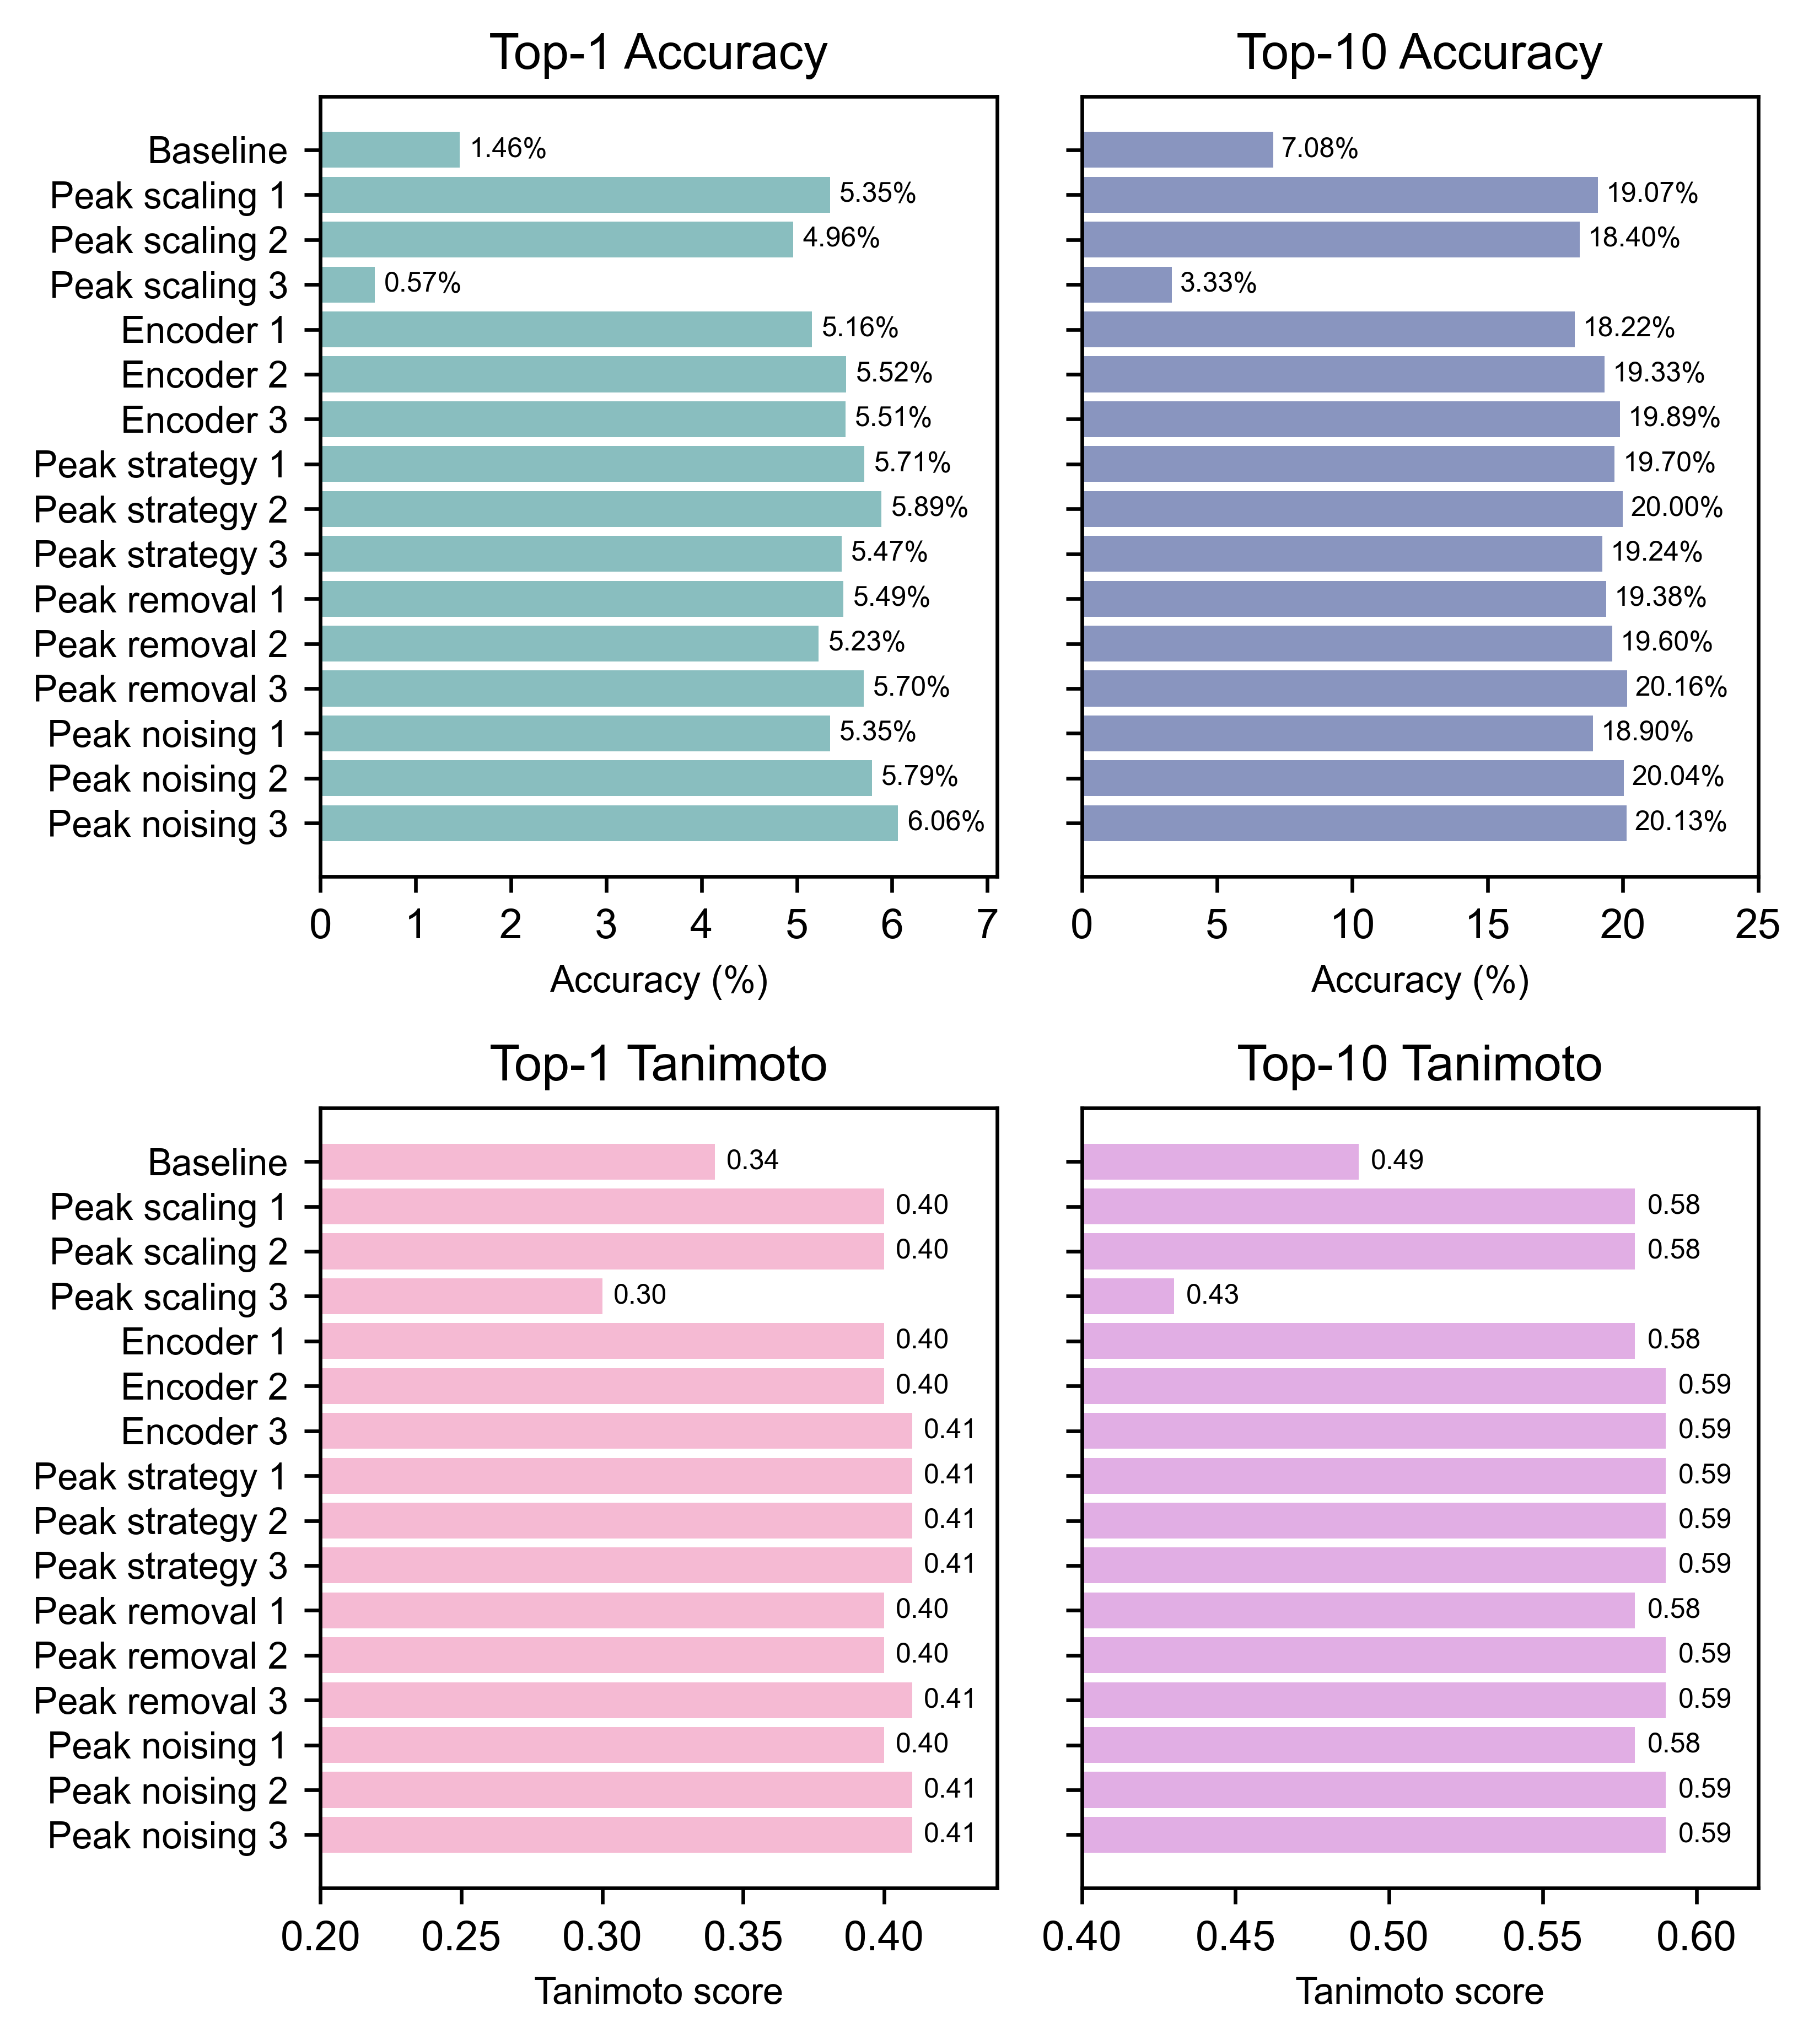

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
fs=9
plt.rcParams.update({'font.size': fs})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

# Data
data = {
    "Experiment": [
        "Baseline", "Peak scaling 1", "Peak scaling 2", "Peak scaling 3",
        "Encoder 1", "Encoder 2", "Encoder 3",
        "Peak strategy 1", "Peak strategy 2", "Peak strategy 3",
        "Peak removal 1", "Peak removal 2", "Peak removal 3",
        "Peak noising 1", "Peak noising 2", "Peak noising 3"

    ],
    "Top-1 Accuracy": [1.46, 5.35, 4.96, 0.57, 
                       5.16, 5.52, 5.51, 
                       5.71, 5.89, 5.47, 
                       5.49, 5.23, 5.70,
                       5.35, 5.79, 6.06],
    "Top-1 Tanimoto": [0.34, 0.40, 0.40, 0.30, 
                       0.40, 0.40, 0.41, 
                       0.41, 0.41, 0.41,
                       0.40, 0.40, 0.41,
                       0.40, 0.41, 0.41],
    "Top-10 Accuracy": [7.08, 19.07, 18.4, 3.33, 
                        18.22, 19.33, 19.89, 
                        19.7, 20.0, 19.24,
                        19.38, 19.60, 20.16,
                        18.90, 20.04, 20.13],
    "Top-10 Tanimoto": [0.49, 0.58, 0.58, 0.43, 
                        0.58, 0.59, 0.59, 
                        0.59, 0.59, 0.59,
                        0.58, 0.59, 0.59, 
                        0.58, 0.59, 0.59],
    "Validity (%)": [
        93.44, 95.17, 95.12, 96.30,
        95.48, 95.28, 95.17,
        95.03, 95.11, 95.20,
        95.38, 95.35, 95.33,
        95.17, 95.24, 95.13
    ]
}

df = pd.DataFrame(data)
experiments = df["Experiment"].values
y_pos = np.arange(len(experiments))

# Colors
colors = ['#89bebf', '#8995BF', '#f5bad3', '#e1aee4']

# Figure
fig, axes = plt.subplots(2, 2, figsize=(400/72, 180/72*2.5), dpi=600, sharey=True)

# Top-1 Accuracy
bars1 = axes[0,0].barh(y_pos, df["Top-1 Accuracy"], color=colors[0])
axes[0,0].set_yticks(y_pos)
axes[0,0].set_yticklabels(experiments, fontsize=fs-1)
axes[0,0].set_xlabel("Accuracy (%)", fontsize=fs-1)
axes[0,0].set_title("Top-1 Accuracy")
axes[0,0].set_xlim([0,7.1])
axes[0,0].set_xticks(np.linspace(0, 7, 8))
for bar, val in zip(bars1, df["Top-1 Accuracy"]):
    axes[0,0].text(val + 0.1, bar.get_y() + bar.get_height()/2,
                   f"{val:.2f}%", va='center', fontsize=fs-3)

# Top-10 Accuracy
bars2 = axes[0,1].barh(y_pos, df["Top-10 Accuracy"], color=colors[1])
axes[0,1].set_yticks(y_pos)
axes[0,1].set_xlabel("Accuracy (%)", fontsize=fs-1)
axes[0,1].set_title("Top-10 Accuracy")
axes[0,1].set_xlim([0,25])
axes[0,1].set_xticks(np.linspace(0, 25, 6))

for bar, val in zip(bars2, df["Top-10 Accuracy"]):
    axes[0,1].text(val + 0.3, bar.get_y() + bar.get_height()/2,
                   f"{val:.2f}%", va='center', fontsize=fs-3)

# Top-1 Tanimoto
bars3 = axes[1,0].barh(y_pos, df["Top-1 Tanimoto"], color=colors[2])
axes[1,0].set_yticks(y_pos)
axes[1,0].set_yticklabels(experiments, fontsize=fs-1)
axes[1,0].set_xlabel("Tanimoto score", fontsize=fs-1)
axes[1,0].set_title("Top-1 Tanimoto")
axes[1,0].set_xlim([0.2,0.44])
axes[1,0].set_xticks(np.linspace(0.2, 0.4, 5))

for bar, val in zip(bars3, df["Top-1 Tanimoto"]):
    axes[1,0].text(val + 0.004, bar.get_y() + bar.get_height()/2,
                   f"{val:.2f}", va='center', fontsize=fs-3)

# Top-10 Tanimoto
bars4 = axes[1,1].barh(y_pos, df["Top-10 Tanimoto"], color=colors[3])
axes[1,1].set_yticks(y_pos)
axes[1,1].invert_yaxis()
axes[1,1].set_xlabel("Tanimoto score", fontsize=fs-1)
axes[1,1].set_title("Top-10 Tanimoto")
axes[1,1].set_xlim([0.4,0.62])
axes[1,1].set_xticks(np.linspace(0.4, 0.6, 5))

for bar, val in zip(bars4, df["Top-10 Tanimoto"]):
    axes[1,1].text(val + 0.004, bar.get_y() + bar.get_height()/2,
                   f"{val:.2f}", va='center', fontsize=fs-3)

plt.tight_layout()
plt.savefig('figs/2x2_results.png', dpi=600)
plt.show()


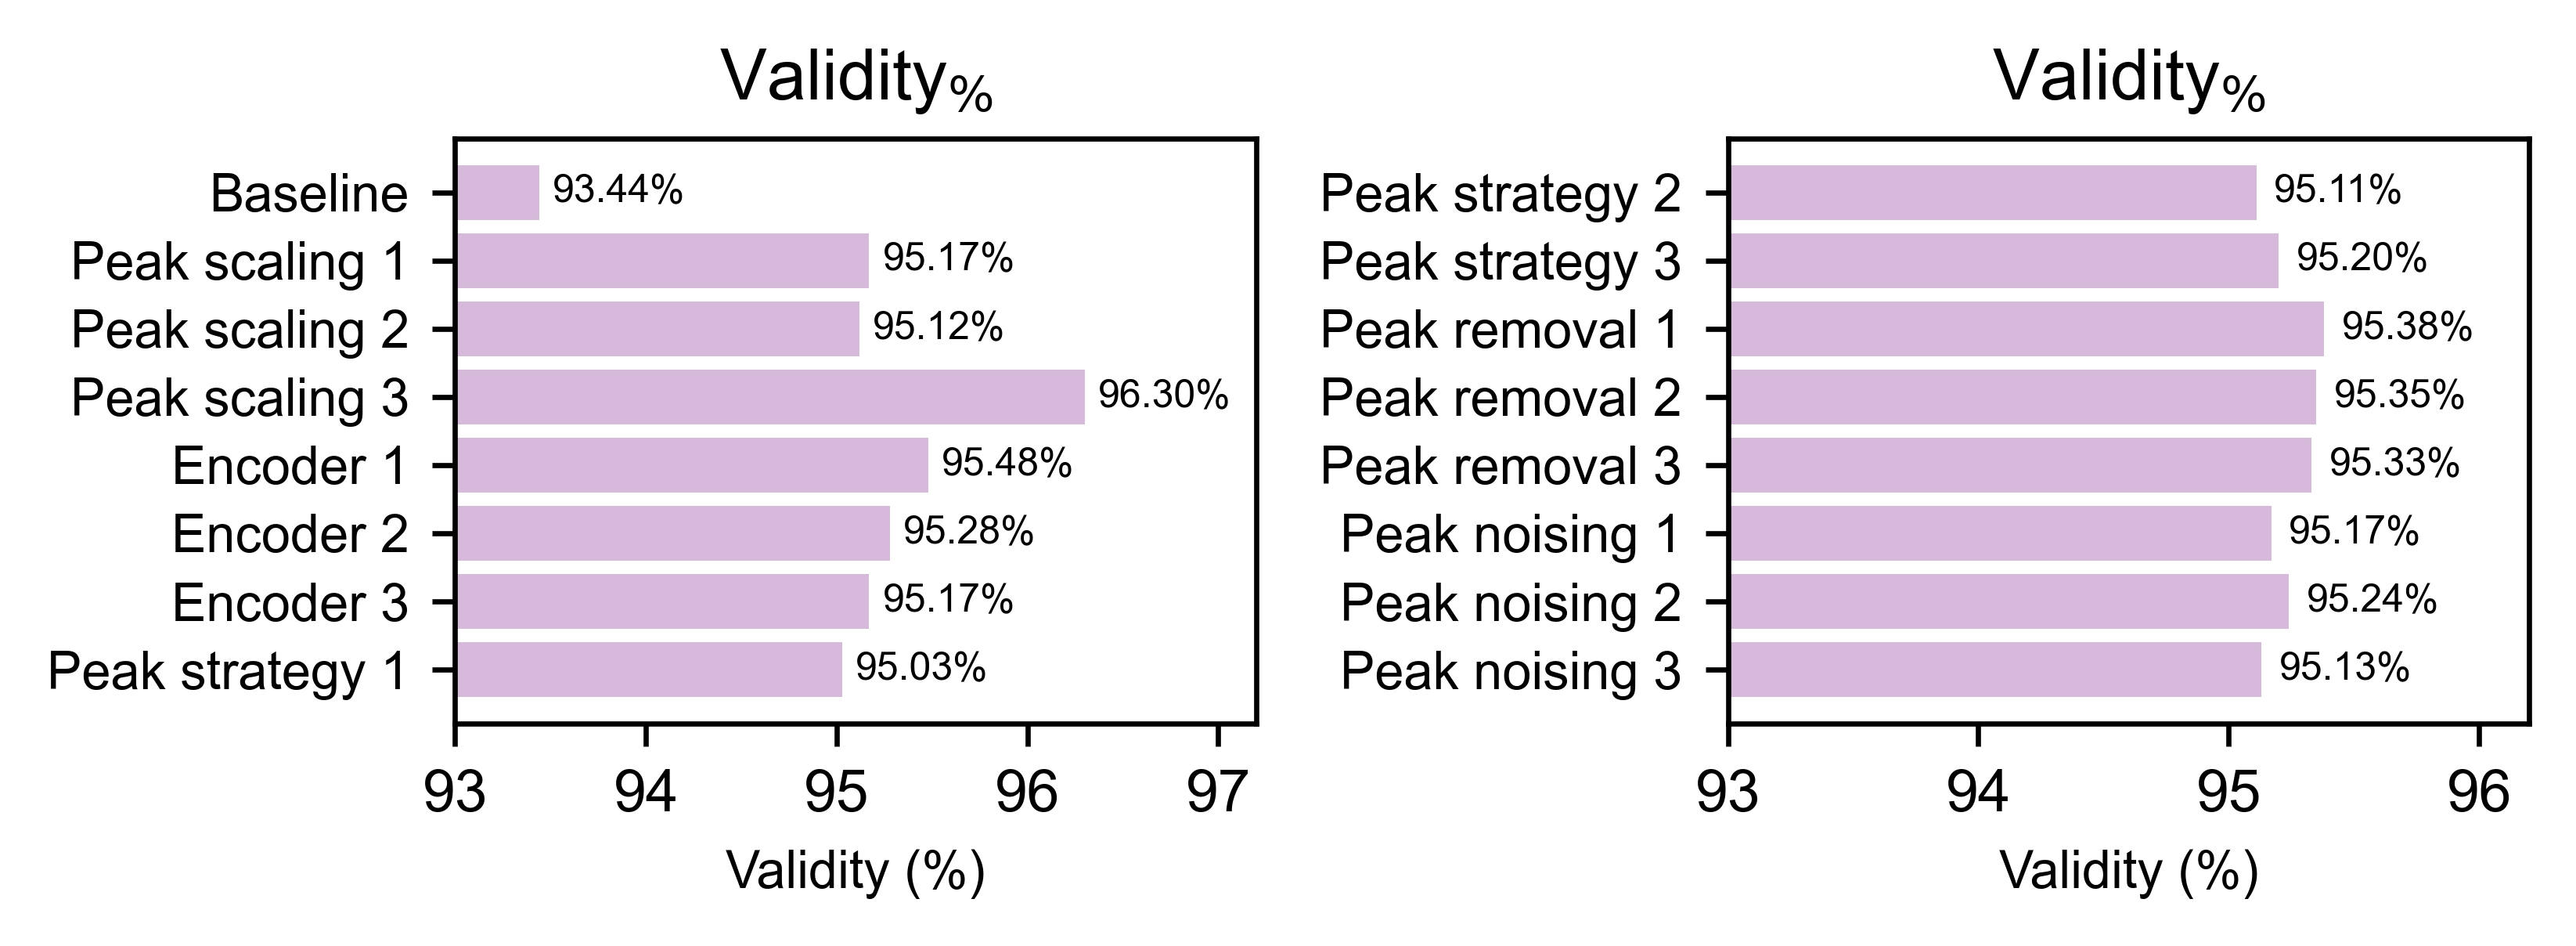

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    "Experiment": [
        "Baseline", "Peak scaling 1", "Peak scaling 2", "Peak scaling 3",
        "Encoder 1", "Encoder 2", "Encoder 3",
        "Peak strategy 1", "Peak strategy 2", "Peak strategy 3",
        "Peak removal 1", "Peak removal 2", "Peak removal 3",
        "Peak noising 1", "Peak noising 2", "Peak noising 3"
    ],
    "Validity (%)": [
        93.44, 95.17, 95.12, 96.30,
        95.48, 95.28, 95.17,
        95.03, 95.11, 95.20,
        95.38, 95.35, 95.33,
        95.17, 95.24, 95.13
    ]
}

df = pd.DataFrame(data)

# Split into two halves
mid = len(df) // 2
df1 = df.iloc[:mid]
df2 = df.iloc[mid:]

# Figure
fig, axes = plt.subplots(1, 2, figsize=(400/72, 150/72), dpi=600)

# Colors
color = "#d7badb"

# First half
y_pos1 = np.arange(len(df1))
bars1 = axes[0].barh(y_pos1, df1["Validity (%)"], color=color)
axes[0].set_yticks(y_pos1)
axes[0].set_yticklabels(df1["Experiment"], fontsize=fs-1)
axes[0].set_xlabel("Validity (%)", fontsize=fs-1)
axes[0].set_xlim([93, 97.2])
axes[0].set_xticks(np.linspace(93, 97, 5))
axes[0].set_title("Validity$_\%$")
for bar, val in zip(bars1, df1["Validity (%)"]):
    axes[0].text(val + 0.07, bar.get_y() + bar.get_height()/2,
                 f"{val:.2f}%", va='center', fontsize=fs-3)
axes[0].invert_yaxis()

# Second half
y_pos2 = np.arange(len(df2))
bars2 = axes[1].barh(y_pos2, df2["Validity (%)"], color=color)
axes[1].set_yticks(y_pos2)
axes[1].set_yticklabels(df2["Experiment"], fontsize=fs-1)
axes[1].set_xlabel("Validity (%)", fontsize=fs-1)
axes[1].set_xticks(np.linspace(93, 97, 5))
axes[1].set_xlim([93, 96.2])
axes[1].set_title("Validity$_\%$")
for bar, val in zip(bars2, df2["Validity (%)"]):
    axes[1].text(val + 0.07, bar.get_y() + bar.get_height()/2,
                 f"{val:.2f}%", va='center', fontsize=fs-3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig("figs/validity_split.png", dpi=600)
plt.show()


In [ ]:
dfs[1].to_csv('df.csv')